<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e ~/Workspace/AI4Finance/FinRL

In [18]:
!pip install -e ~/Workspace/AI4Finance/FinRL

Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ug4ewly1/elegantrl_45c6ddb5681a45c78fe7a8a782965036
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ug4ewly1/elegantrl_45c6ddb5681a45c78fe7a8a782965036
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.stablebaselines3.models import hyperparameterized_model_name, MODELS


from pprint import pprint

import sys
import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [19]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-11'
TEST_END_DATE = '2024-11-11'

INDICATORS = ['log-ret', 'rsi_30', 'dx_30', 'close_-7_s', 'close_-14_s', 'close_-30_s', 'close_-60_s']

In [20]:
CUSTOM_TICKER = [
    "INTC",
    "F",
    "PARA",
    "LVS"
]

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [23]:
if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['log-ret'] = 100*processed['log-ret']
    processed['close_-7_s'] = 100*(processed['close_-7_s'] - processed['close'])/processed['close_-7_s']
    processed['close_-14_s'] =  100*(processed['close_-14_s'] - processed['close'])/processed['close_-14_s']
    processed['close_-30_s'] =  100*(processed['close_-30_s'] - processed['close'])/processed['close_-30_s']
    processed['close_-60_s'] =  100*(processed['close_-60_s'] - processed['close'])/processed['close_-60_s']


    processed.to_csv("datasets/processed.csv", index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (14956, 8)
Successfully added technical indicators
Successfully added turbulence index


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [24]:
processed

,date,open,high,low,close,volume,tic,day,log-ret,rsi_30,dx_30,close_-7_s,close_-14_s,close_-30_s,close_-60_s,turbulence
0,2010-01-04,5.679181,10.280000,10.280000,10.170000,60855800,F,0,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-04,13.519426,20.879999,21.030001,20.790001,47800900,INTC,0,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2010-01-04,10.810488,16.620001,16.620001,15.600000,36415700,LVS,0,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2010-01-04,11.007925,14.250000,14.400000,14.210000,6710900,PARA,0,0.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2010-01-05,6.054847,10.960000,11.240000,10.450000,215620200,F,1,2.715974,100.000000,100.000000,-2.753193,-2.753193,-2.753193,-2.753193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,2024-11-07,11.530000,11.530000,11.550000,11.370000,10617900,PARA,3,1.328037,58.830617,60.194075,-9.432142,-8.699807,-7.264146,-10.388346,2.483706
14952,2024-11-08,10.970000,10.970000,10.970000,10.930000,45463400,F,4,-0.729264,50.256766,16.108131,-5.096161,1.353787,-0.830260,-5.400197,2.207823
14953,2024-11-08,26.200001,26.200001,26.430000,26.000000,76428000,INTC,4,2.216695,58.473983,42.769193,-15.967885,-14.993363,-7.615895,-27.952758,2.207823
14954,2024-11-08,50.380001,50.380001,50.750000,50.549999,8699100,LVS,4,-1.550725,56.049189,3.759871,4.370037,1.519584,-1.099998,-26.978140,2.207823


In [25]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 4, State Space: 37


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [28]:
import random
import copy
def generate_hyperparams_list_from_code(num_variations=5, duplication=4):
    hyperparams_list = []

    # PPO Variations
    PPO_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'n_steps': [256, 512, 1024, 2048],
        'batch_size': [64, 128],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3],
        'clip_range': [0.2, 0.3],
        'gae_lambda': [0.95, 0.98]
    }

    # A2C Variations
    A2C_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3, 0.0007],
        'n_steps': [5, 10, 20],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3, 0.005],
        'normalize_advantage': [True, False],
        'use_rms_prop': [True, False]
    }

    # DDPG Variations
    DDPG_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # SAC Variations
    SAC_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'ent_coef': ['auto'],
    }

    # TD3 Variations
    TD3_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # Timesteps Variations
    timesteps_variations = {
        'a2c': [10000],
        'ppo': [10000],
        'ddpg': [10000],
        'sac': [10000],
        'td3': [10000]
    }

    hyperparams_list = []
    for i in range(num_variations):
        A2C_kwargs = {k: random.choice(v) for k, v in A2C_variations.items()}
        PPO_kwargs = {k: random.choice(v) for k, v in PPO_variations.items()}
        DDPG_kwargs = {k: random.choice(v) for k, v in DDPG_variations.items()}
        SAC_kwargs = {k: random.choice(v) for k, v in SAC_variations.items()}
        TD3_kwargs = {k: random.choice(v) for k, v in TD3_variations.items()}
        timesteps_dict = {k: random.choice(v) for k, v in timesteps_variations.items()}

        # Assign a unique name to each set
        for j in range(duplication):
            name = f"variant_{j+1}"
            print(name)

            A2C_kwargs['name'] = name
            PPO_kwargs['name'] = name
            DDPG_kwargs['name'] = name
            SAC_kwargs['name'] = name
            TD3_kwargs['name'] = name

            hyperparam = {
                'A2C_model_kwargs': A2C_kwargs,
                'PPO_model_kwargs': PPO_kwargs,
                'DDPG_model_kwargs': DDPG_kwargs,
                'SAC_model_kwargs': SAC_kwargs,
                'TD3_model_kwargs': TD3_kwargs,
                'timesteps_dict': timesteps_dict
            }

            hyperparams_list.append(copy.deepcopy(hyperparam))

    return hyperparams_list

In [29]:
hyperparams_list = generate_hyperparams_list_from_code(num_variations=5, duplication=10)

variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10


In [30]:
import ray
import random
import numpy as np
import torch

ray.init(ignore_reinit_error=True)

@ray.remote
def run_ensemble_with_params(hyperparams, seed, processed):

    #np.random.seed(seed)
    #random.seed(seed)
    #torch.manual_seed(seed)
    rebalance_window = 100
    validation_window = 300

    A2C_model_kwargs = hyperparams['A2C_model_kwargs']
    PPO_model_kwargs = hyperparams['PPO_model_kwargs']
    DDPG_model_kwargs = hyperparams['DDPG_model_kwargs']
    SAC_model_kwargs = hyperparams['SAC_model_kwargs']
    TD3_model_kwargs = hyperparams['TD3_model_kwargs']
    timesteps_dict = hyperparams['timesteps_dict']

    env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

    # Instantiate and run the ensemble agent
    ensemble_agent = DRLEnsembleAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
        val_test_period=(TEST_START_DATE, TEST_END_DATE),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    df_summary = ensemble_agent.run_ensemble_strategy(
        A2C_model_kwargs,
        PPO_model_kwargs,
        DDPG_model_kwargs,
        SAC_model_kwargs,
        TD3_model_kwargs,
        timesteps_dict
    )

    return df_summary

2024-11-29 18:35:27,754	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


In [15]:
ray.shutdown()


(run_ensemble_with_params pid=46064) ------------------------------------------- [repeated 8x across cluster]
(run_ensemble_with_params pid=46064) |    approx_kl            | 0.00018959062 | [repeated 9x across cluster]
(run_ensemble_with_params pid=46064) |    clip_fraction        | 0             | [repeated 9x across cluster]
(run_ensemble_with_params pid=46064) |    clip_range           | 0.2           | [repeated 9x across cluster]
(run_ensemble_with_params pid=46064) |    loss                 | 0.0834        | [repeated 9x across cluster]
(run_ensemble_with_params pid=46064) |    policy_gradient_loss | -0.00163      | [repeated 9x across cluster]
(run_ensemble_with_params pid=46066) ------------------------------------------ [repeated 14x across cluster]
(run_ensemble_with_params pid=46065) --------------------------------- [repeated 174x across cluster]
(run_ensemble_with_params pid=46068) | loss/            |             | [repeated 287x across cluster]
(run_ensemble_with_params

In [31]:
seeds = [42]
futures = []

for seed in seeds:
    for hyperparams in hyperparams_list:
        future = run_ensemble_with_params.remote(
            hyperparams,
            seed,
            processed
        )
        futures.append(future)

results = ray.get(futures)
for df_summary in results:
    print(df_summary)

  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  400  2022-11-14  2024-01-26        PPO   0.035648   0.133885     0.08048   

  SAC Sharpe TD3 Sharpe  
0  -0.027565   0.062641  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  400  2022-11-14  2024-01-26        PPO   -0.06346    0.03158    0.027366   

  SAC Sharpe TD3 Sharpe  
0  -0.027565  -0.062678  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  400  2022-11-14  2024-01-26       DDPG   0.098025   0.044422    0.137632   

  SAC Sharpe TD3 Sharpe  
0   0.120941   0.102992  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  400  2022-11-14  2024-01-26        A2C   0.119065    0.07007   -0.042593   

  SAC Sharpe TD3 Sharpe  
0    0.01563  -0.024579  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  400  2022-11-14  2024-01-26        PPO   0.006091    0.15297   -0.027565  

In [32]:
run_reports = []
for hyperparam in hyperparams_list:
    for k, v in hyperparam.items():
        if 'model_kwargs' in k:
            model_name = k.split('_')[0].lower()
            run_reports.append([hyperparameterized_model_name(model_name, v),
                        model_name, v])

performance_stats = pd.DataFrame(run_reports, columns=['hash_id', 'model_name', 'config'])

In [33]:
performance_stats

,hash_id,model_name,config
0,22356d7b8a5f262e2c852ecdd1a36eaa,a2c,"{'learning_rate': 0.0001, 'n_steps': 10, 'gamm..."
1,b5d833ef0b9f382ff311c4ba54491c9f,ppo,"{'learning_rate': 1e-05, 'n_steps': 2048, 'bat..."
2,05122fff4a5f142b5f4eb3f308d06d29,ddpg,"{'learning_rate': 0.001, 'batch_size': 64, 'bu..."
3,95585e349ffa99db30b2387fc3d5d7e9,sac,"{'learning_rate': 0.001, 'batch_size': 128, 'b..."
4,4c3d3dbd7336897bb2e6fa0a1279532d,td3,"{'learning_rate': 0.001, 'batch_size': 128, 'b..."
...,...,...,...
245,e24c0c3091cdda6a19572c45e3a58f57,a2c,"{'learning_rate': 0.001, 'n_steps': 20, 'gamma..."
246,5095462f4772e2e7de8312c28bfe232a,ppo,"{'learning_rate': 1e-05, 'n_steps': 1024, 'bat..."
247,3bc754108b3ab54f7511ca11090456ec,ddpg,"{'learning_rate': 0.001, 'batch_size': 64, 'bu..."
248,cefbac453bd286fab8d6525eaf700d5f,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '..."


In [34]:
portfolio_return = []
for i, row in performance_stats.iterrows():
    r = (list(pd.read_csv(f'results/account_value_validation_{row["hash_id"]}_400.csv')['account_value'])[-1]/1000000) - 1
    portfolio_return.append(r)

performance_stats['r'] = portfolio_return


In [35]:
import hashlib
performance_stats['config_str'] = [hashlib.md5(str({z for z in x.items() if z[0] != 'name'}).encode()).hexdigest()  for x in performance_stats['config']]

In [40]:
performance_stats.sort_values(['r'])

,hash_id,model_name,config,r,config_str
9,8d04ac0e26818912a7204fa8cd68dbb9,td3,"{'learning_rate': 0.001, 'batch_size': 128, 'b...",-0.340844,149ff25f30f4b360a778f12b657f7708
180,d0d135783890a33c542f4c4704ddcf85,a2c,"{'learning_rate': 0.0007, 'n_steps': 20, 'gamm...",-0.299934,227ef1bd786b1fe24b89e72614604728
228,4d15df3c680593f6482c88cc426d4ecd,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '...",-0.289621,32a84dd75a36d065f1d5b101e454d838
178,4d15df3c680593f6482c88cc426d4ecd,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '...",-0.289621,32a84dd75a36d065f1d5b101e454d838
80,797f218573ff3e369011b92518ef8275,a2c,"{'learning_rate': 0.0007, 'n_steps': 10, 'gamm...",-0.284181,627d7b118e188f5ab3f7f00aea61a485
...,...,...,...,...,...
83,fd9fd3e1288e22a857f30c44645d8997,sac,"{'learning_rate': 0.001, 'batch_size': 128, 'b...",0.765652,842114df54f4021dc57f8699c1b779aa
34,d4d1805323cb87f6cbf3f5e3e76a3a15,td3,"{'learning_rate': 0.001, 'batch_size': 128, 'b...",0.765652,149ff25f30f4b360a778f12b657f7708
107,bada91a7724d39488538feba9ae5ecff,ddpg,"{'learning_rate': 0.001, 'batch_size': 128, 'b...",0.765652,c64042d6af494121ed29b06f2593b919
197,42990f447ea692929bb19f84fe4ce512,ddpg,"{'learning_rate': 0.0001, 'batch_size': 128, '...",0.765652,84bd19c6bf20bb3a73c46870bf659557


In [ ]:
best_models_ = {
    'a2c': 'trained_model/210871e0535ee3313f8053f76e6791d0_10k_400.zip',
    'ddpg': 'trained_model/42990f447ea692929bb19f84fe4ce512_10k_400.zip',
    'td3': 'trained_model/d4d1805323cb87f6cbf3f5e3e76a3a15_10k_400.zip',
    'sac': 'trained_model/fd9fd3e1288e22a857f30c44645d8997_10k_400.zip',
    'ppo': 'trained_model/f39725b2d259df800dc97ca95f52fbb0_10k_400.zip'
}



In [37]:
performance_stats.groupby('model_name').agg(
    avg=('r', 'mean'),
    std=('r', 'std')
)

,avg,std
model_name,,
a2c,0.071830,0.236720
ddpg,0.116194,0.230932
ppo,0.087265,0.144802
sac,0.111438,0.273503
td3,0.092376,0.228294


In [38]:
performance_stats.to_csv("performance_stats_portfolio_5_variation_10_duplication.csv")

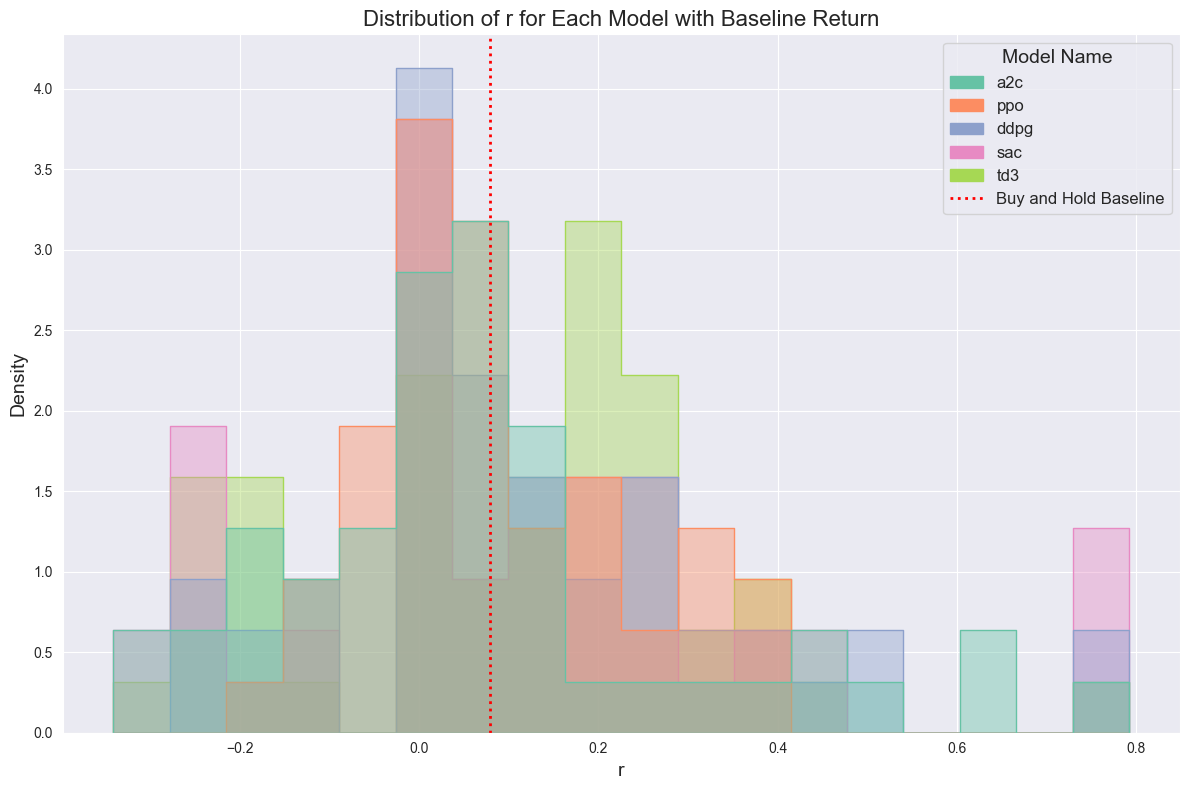

In [43]:
import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Define the baseline return
baseline_return = 0.079  # Adjust based on your actual baseline

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot the distribution with Seaborn's histplot
ax = sns.histplot(
    data=performance_stats,
    x='r',
    hue='model_name',
    kde=False,
    element='step',
    stat='density',
    common_norm=False,
    alpha=0.4,  # Increased alpha for better visibility
    palette='Set2',
    legend=False  # Disable automatic legend for manual control
)

# Add red vertical dotted line for baseline return
baseline_line = plt.axvline(
    x=baseline_return,
    color='red',
    linestyle='dotted',
    linewidth=2,
    label='Buy and Hold Baseline'
)

# Create custom legend handles for models
model_names = performance_stats['model_name'].unique()
model_colors = sns.color_palette('Set2', n_colors=len(model_names))
model_patches = [Patch(color=model_colors[i], label=model_names[i]) for i in range(len(model_names))]

# Create a custom legend handle for the baseline
baseline_handle = Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='Buy and Hold Baseline')

# Combine all legend handles
handles = model_patches + [baseline_handle]
labels = [patch.get_label() for patch in model_patches] + [baseline_handle.get_label()]

# Add the combined legend to the plot
plt.legend(handles=handles, labels=labels, title='Model Name', fontsize=12, title_fontsize=14)

# Customize the plot
plt.title('Distribution of r for Each Model with Baseline Return', fontsize=16)
plt.xlabel('r', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()

# Display the plot
plt.show()


In [1]:
%load_ext tensorboard



In [2]:
%tensorboard --logdir tensorboard_log/


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [54]:
rebalance_window = 100
validation_window = 300


In [55]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [56]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

FileNotFoundError: [Errno 2] No such file or directory: 'results/account_value_trade_ensemble_400.csv'

In [17]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2024-01-26,NaN,2024-01-26
1,999948.581878,2024-01-29,-0.000051,2024-01-29
2,999936.210695,2024-01-30,-0.000012,2024-01-30
3,999601.844153,2024-01-31,-0.000334,2024-01-31
4,999829.587885,2024-02-01,0.000228,2024-02-01


In [57]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Convert the date column to datetime format
#df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
#df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'account_value'

<Figure size 1200x600 with 0 Axes>

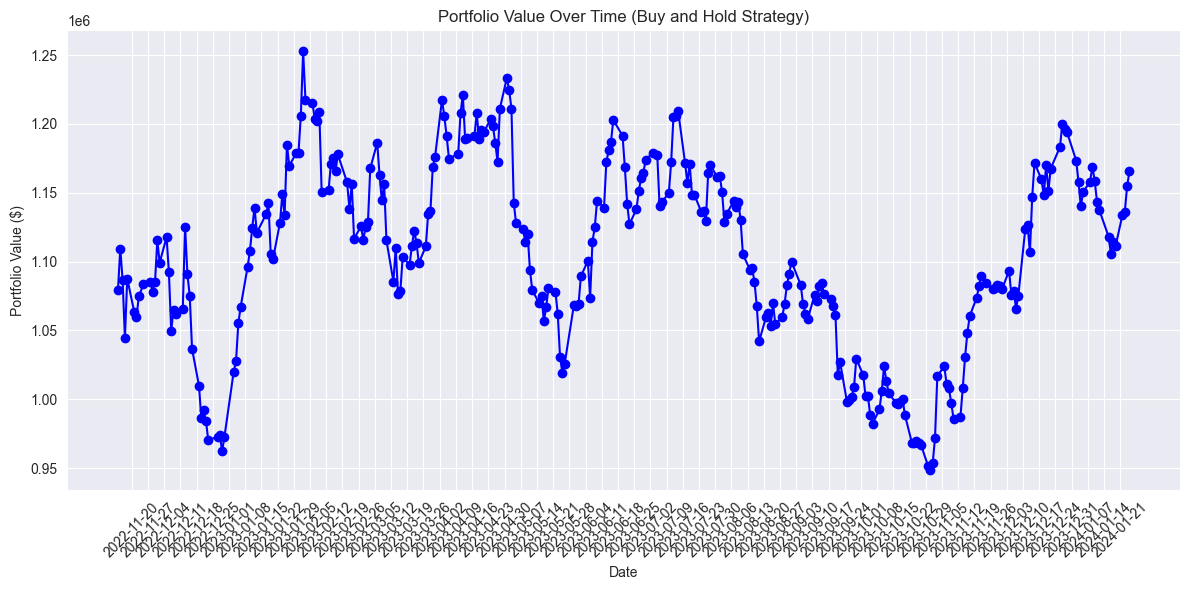

Annual return          0.066493
Cumulative returns     0.079650
Annual volatility      0.273524
Sharpe ratio           0.372302
Calmar ratio           0.274205
Stability              0.026762
Max drawdown          -0.242492
Omega ratio            1.062624
Sortino ratio          0.544436
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007757
Daily value at risk   -0.034057
dtype: float64


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2022-11-14')
end_date = pd.to_datetime('2024-01-25')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



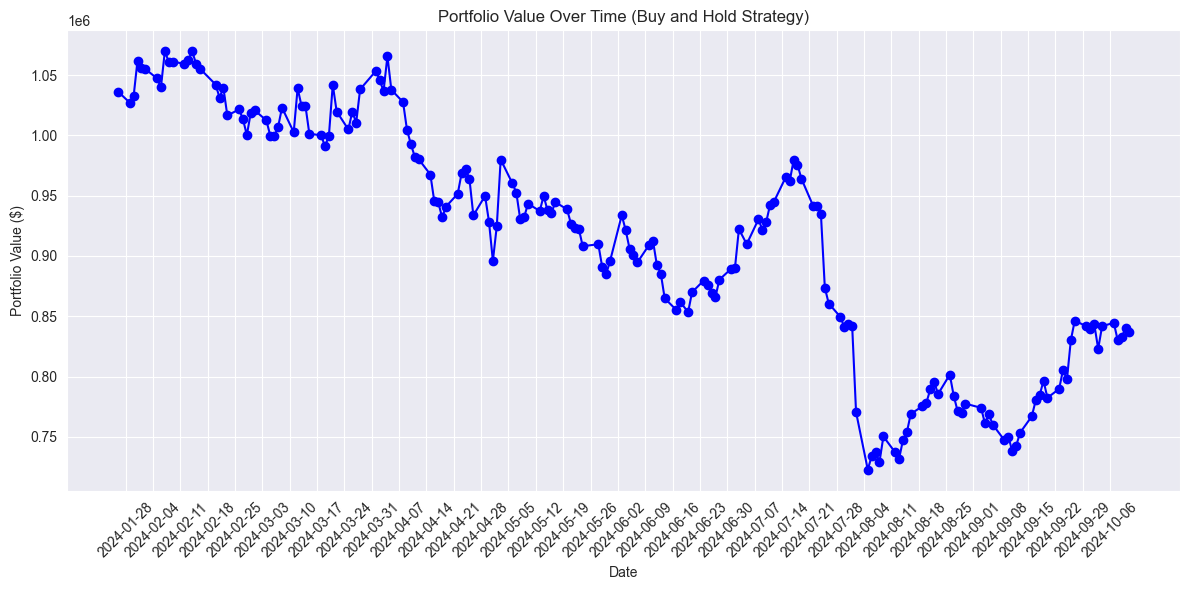

Annual return         -0.259010
Cumulative returns    -0.192749
Annual volatility      0.291997
Sharpe ratio          -0.885534
Calmar ratio          -0.798794
Stability              0.786265
Max drawdown          -0.324251
Omega ratio            0.861795
Sortino ratio         -1.190751
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.232643
Daily value at risk   -0.037814
dtype: float64


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2024-01-26')
end_date = pd.to_datetime('2024-10-11')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
df_account_value = df_account_value.reset_index()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();